In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/FYP

/content/drive/MyDrive/FYP


In [3]:
%run VideoModel.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


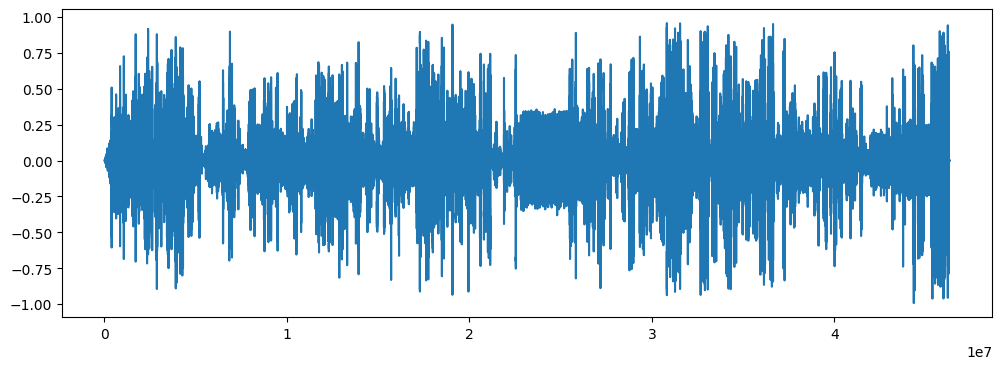

Lispettore Derrick - Chi ha ucciso Johann Kahl 691979.mp4
Paris Mon Paradis (Film Burkinabè) - Sous-titré français - Film complet.mp4
Sword of Vengeance - Nigeria Nollywood Movie.mp4
The Executioners Song 1982 Tommy Lee Jones Eli Wallach Full Length Movie.mp4
Agents of Secret Stuff.mp4
Berkeley Square 10 BBC 1998 (Último capítulo de la serie) (Last Chapter).mp4
Distorting Mirror of the Soul Episode 2 Russian TV Series StarMedia Melodrama English Subtitles.mp4
Kill Stalin - Episode 6 Russian TV Series StarMedia Military Drama English Subtitles.mp4
palace treasure 1 - Nigeria Nollywood movie (online-audio-converter.com) 2.mp3
Petites coupures (online-audio-converter.com).mp3
Greatest Kung Fu movie ever!.mp3
The Trap.m4a
Gröna hissen - Hela föreställningen från 2010 med Johan Ulveson och Eva.m4a
Eterna sonrisa de New Jersey con Daniel Day Lewis -.m4a
Return of the Tiger.m4a
Jest Sprawa [Komedia Polska 2002].m4a
L'ispettore Derrick - La tentazione 631979.m4a
Checkpoint 1956.m4a
គិ

In [4]:
%run AudioModel.ipynb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Determining optimal number of clusters..


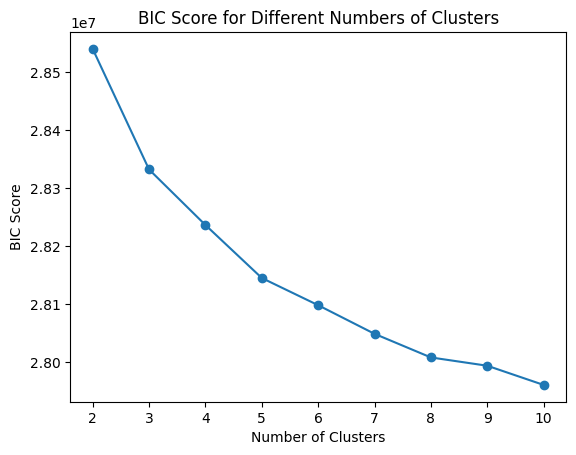

Optimal Number of Clusters: 10
Training GMM with 10 clusters..
Training Done
                   Audio SpeakerLabel  StartTime  EndTime  TimeSeconds
0    Checkpoint 1956.wav    Speaker 0       3.04    22.08        19.04
1    Checkpoint 1956.wav    Speaker 9      22.08    28.08         6.00
2    Checkpoint 1956.wav    Speaker 4      28.08    34.08         6.00
3    Checkpoint 1956.wav    Speaker 7      34.08    52.08        18.00
4    Checkpoint 1956.wav    Speaker 3      52.08    55.08         3.00
..                   ...          ...        ...      ...          ...
708  Checkpoint 1956.wav    Speaker 8    4763.74  4776.18        12.44
709  Checkpoint 1956.wav    Speaker 2    4776.18  4782.22         6.04
710  Checkpoint 1956.wav    Speaker 8    4782.22  4793.86        11.64
711  Checkpoint 1956.wav    Speaker 0    4793.86  4799.48         5.62
712  Checkpoint 1956.wav    Speaker 7    4799.48  4797.24        -2.24

[713 rows x 5 columns]


In [5]:
%run SpeakerDiarization.ipynb

In [6]:
%run AVFusion.ipynb

In [7]:
%run ActiveSpeakerDetection.ipynb

In [8]:
!pip install wavio

In [ ]:
from moviepy.video.io.VideoFileClip import VideoFileClip
import cv2
from google.colab.patches import cv2_imshow
import wavio
import numpy as np
import librosa
import os
import PIL.Image
from IPython.display import display, clear_output

# Define the output file path
output_audio_path = "output_audio.wav"
active_speaker = 'None'
output_frames_folder = "output_frames"
os.makedirs(output_frames_folder, exist_ok=True)  # Create the folder if it doesn't exist



# Load the video clip
video_path = "/content/drive/MyDrive/FYP/demo_video.mp4"
video_clip = VideoFileClip(video_path)
segLen=3

output_video_path = "output_demo_video.mp4"

# Initialize OpenCV video capture for video frames
cap = cv2.VideoCapture(video_path)
frame_count=0
frame_rate=video_clip.fps

fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for the output video (other options are 'XVID', 'MJPG', etc.)
f_height, f_width, channels = video_clip.get_frame(0).shape
out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (f_width, f_height))
target_size=(f_width, f_height)
frame_skip = 5

# Iterate through each frame of the video
# for frame_time in np.arange(0, video_clip.duration, 1 / video_clip.fps):
for frame_num in range(int(video_clip.fps * video_clip.duration)):
    if frame_num % frame_skip != 0:
        continue
    frame_time = frame_num / video_clip.fps
    video_frame = video_clip.get_frame(frame_time)
    original_frame = video_frame.copy()
    try:
      if frame_count != 0:
        # Read audio segment for the current frame
        audio_segment = video_clip.audio.subclip(frame_time, frame_time + 1)  # Extract audio for 1 second around the frame
        a_data = audio_segment.to_soundarray()

        # Extracted audio data
        audio_data = a_data
        # Save the audio data as a WAV file
        wavio.write(output_audio_path, audio_data, rate=44100, sampwidth=2)  # Specify the sampling rate

        audio_class,score=audio_model(output_audio_path)
        audio_score = score[0]
        print(audio_class, score)
        # audio_class = 'CLEAN SPEECH'

        # Perform Speaker Diarization here
        if audio_class!='NO SPEEECH':
            wavFile = output_audio_path
            speaker_segments =speakerdiarisationdf(pass1hyp, frame_rate, wavFile)
            speaker_segments["TimeSeconds"] = speaker_segments.EndTime - speaker_segments.StartTime
            print("Speaker diarization output:", speaker_segments)
        else:
            print("No speech detected in the audio.")


        # Process the video_frame and audio_data as needed
        speakers, img1_faces=video_model(prev_frame, video_frame)
        print(speakers, img1_faces)

        if audio_class!='NO SPEECH':

          # Perform AV Fusion here
          fused_scores=av_fusion(speakers, audio_score)
          # print(fused_scores)

          # Find and Focus the Active Speaker here
          active_speaker = speaker_detection(fused_scores, img1_faces)
          # print(active_speaker)

        else:
          active_speaker = 'None'


      print(active_speaker)
      if active_speaker=='None':
        # Output Wide View
        x=0
        y=0
        width=f_width
        height=f_height
        cropped_frame = original_frame[y:y + height, x:x + width]

      else:
        # Crop Frame
        x1 = active_speaker[0]-50
        y1 = active_speaker[1]-30
        x2 = active_speaker[2]+50
        y2 = active_speaker[3]+30

        # Crop the region from the frame
        cropped_frame = original_frame[y1:y2, x1:x2]
      cv2_imshow(cropped_frame)
      new_frame = cv2.resize(cropped_frame, target_size)
      out.write(cv2.cvtColor(new_frame, cv2.COLOR_RGB2BGR))
      # Save the processed frame as an image file
      frame_filename = os.path.join(output_frames_folder, f"frame_{frame_num:04d}.jpg")
      cv2.imwrite(frame_filename, cv2.cvtColor(new_frame, cv2.COLOR_RGB2BGR))
    except:
      cv2_imshow(original_frame)
      new_frame = cv2.resize(original_frame, target_size)
      out.write(cv2.cvtColor(new_frame, cv2.COLOR_RGB2BGR))
      # Save the processed frame as an image file
      frame_filename = os.path.join(output_frames_folder, f"frame_{frame_num:04d}.jpg")
      cv2.imwrite(frame_filename, cv2.cvtColor(new_frame, cv2.COLOR_RGB2BGR))



    # Display the cropped frame
    img_frame = PIL.Image.fromarray(new_frame)

    # Display the video frame using PIL.Image
    display(img_frame)

    prev_frame=original_frame
    frame_count+=1
      # You can also play audio_data here using an audio library like 'pydub'

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture
cap.release()
out.release()
cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [8]:
from moviepy.editor import VideoFileClip, VideoClip

# Path to the folder containing the processed frames
output_frames_folder = "output_frames"

# List the image files in the folder
frame_files = sorted([f for f in os.listdir(output_frames_folder) if f.endswith(".jpg")])

# Get the frame dimensions from the first frame
first_frame = cv2.imread(os.path.join(output_frames_folder, frame_files[0]))
frame_height, frame_width, _ = first_frame.shape

# Define the output video path
output_video_path = "output_demo_video.mp4"
frame_rate = 4
# Function to load each frame
def load_frame(t):
    frame_num = int(t * frame_rate)
    frame_path = os.path.join(output_frames_folder, frame_files[frame_num])
    return cv2.imread(frame_path)

# Create a VideoClip by loading each frame
output_video = VideoClip(make_frame=load_frame, duration=len(frame_files) / frame_rate)
output_video.fps = frame_rate  # Set the fps attribute

# Write the output video
output_video.write_videofile(output_video_path, codec="libx264")

# Close the video clip
output_video.close()


Moviepy - Building video output_demo_video.mp4.
Moviepy - Writing video output_demo_video.mp4



Moviepy - Done !
Moviepy - video ready output_demo_video.mp4


In [9]:
from IPython.display import Video

# Display the video in the Colab notebook
video_path = "output_demo_video.mp4"
Video(video_path, embed=True)


In [3]:
import os
import cv2